# Analysis of data
In this notebook we'll look at the downloaded data and explore what it tells us

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas
from shapely.geometry import Point, LineString
from datetime import datetime

In [2]:
geo_data_dir = '../data/geo_data'
weather_data_dir = '../data/weather_data'
taxi_zones_file = '../data/taxi_zones'
green_tripdata_file = '../data/taxi_data/consolidated_green_tripdata.csv'
yellow_tripdata_file = '../data/taxi_data/consolidated_yellow_tripdata.csv'

* Load the shape file of NYC (this contains the shape files for each location below) and display it

In [3]:
def get_taxi_zones(taxi_zones_file):
    taxi_zones = geopandas.read_file(taxi_zones_file).set_index('OBJECTID')
    zone_ids = taxi_zones.index.tolist()
    taxi_zones['centroids'] = taxi_zones.geometry.centroid
    return taxi_zones, zone_ids

,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroids
OBJECTID,,,,,,,
1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",POINT (935996.8210162065 191376.749530832)
2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",POINT (1031085.718603285 164018.7544032017)
3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",POINT (1026452.616873473 254265.4786585689)
4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",POINT (990633.9806410479 202959.7823911368)
5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",POINT (931871.3700680139 140681.3513759734)
6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.7466657609 158679.854687795, ...",POINT (964319.735448061 157998.9356119239)
7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.217962816 218919.6406951398,...",POINT (1006496.679158681 216719.2181686789)
8,0.027591,0.000027,Astoria Park,8,Queens,"POLYGON ((1005482.276373357 221686.4661663175,...",POINT (1005551.57117787 222936.0875515854)
9,0.099784,0.000338,Auburndale,9,Queens,"POLYGON ((1043803.993348822 216615.9250395149,...",POINT (1043002.677424325 212969.8490136597)


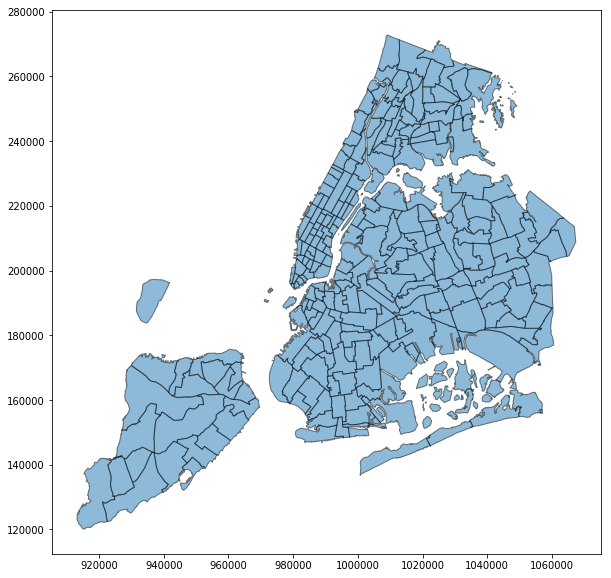

In [4]:
taxi_zones, zone_ids = get_taxi_zones(taxi_zones_file)
taxi_zones.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
taxi_zones.head(10)

### Load the taxi data

Load and cleanse the trip data

In [5]:
def load_tripdata(tripdata_file, zone_ids, min_trip_duration=1, max_trip_duration=60, delimiter=',', save=True): 
    def get_trip_durations(tripdata_file):
        durations = []
        for i, trip in tripdata.iterrows():
            pickup_time = trip['tpep_pickup_datetime']  #"2017-07-01 00:56:23"
            dropoff_time = trip['tpep_dropoff_datetime']  #"2017-07-01 00:59:30"
            duration = datetime.strptime(dropoff_time, '%Y-%m-%d %H:%M:%S') - datetime.strptime(pickup_time, '%Y-%m-%d %H:%M:%S')
            durations.append(duration.seconds / 60)    # Convert to minutes
        return durations
    
    tripdata = pd.read_csv(tripdata_file, delimiter=delimiter)
    print('Loaded trip data from {}'.format(tripdata_file))
    print('Trip data contains {} rows'.format(len(tripdata)))
    # Drop rows with zero and NaN values
    tripdata = tripdata[(tripdata != 0).all(1)].dropna()
    tripdata = tripdata[(tripdata['PULocationID'].isin(zone_ids)) & 
                                (tripdata['DOLocationID'].isin(zone_ids))]
    # Get trip durations and remove outliers
    print('Calculating trip durations for {} rows'.format(len(tripdata)))
    tripdata['duration'] = get_trip_durations(tripdata)
    print('Removing rows with {} < duration < {}'.format(min_trip_duration, max_trip_duration))
    tripdata = tripdata[(tripdata['duration'] >= min_trip_duration ) & ( tripdata['duration'] <= max_trip_duration)]
    # Save and return cleansed data
    print('Cleansed trip data contains {} rows'.format(len(tripdata)))
    if save:
        directory = os.path.dirname(tripdata_file)
        file = os.path.basename(tripdata_file)
        cleansed_file = os.path.join(directory, 'cleansed_{}'.format(file))
        print('Saving cleansed data to {}'.format(cleansed_file))
        tripdata.to_csv(cleansed_file, sep=delimiter)
        print('Done')
    return tripdata       

* Load trip data

In [6]:
tripdata = load_tripdata(yellow_tripdata_file, zone_ids)
tripdata.head(10)

KeyboardInterrupt: 

* Graph trip times

In [ ]:
max_dur_to_plot = 60    # Minutes
plt.hist(tripdata[tripdata['duration'] < max_dur_to_plot]['duration'], color = 'blue', edgecolor = 'black',
         bins = int((max_dur_to_plot)))
plt.title('Histogram of journey times')
plt.xlabel('Journey time (minutes)')
plt.ylabel('Number of samples')

### Restart here

TODO - Start by loading the CSV

In [ ]:
# green_tripdata = pd.read_csv('../data/taxi_data/cleansed_consolidated_green_tripdata.csv', delimiter=',')

* Count of each pickup (PU) and drop-off (DO) location ID

In [ ]:
def count_by_location_ids(tripdata):
    count_by_PU = tripdata.groupby('PULocationID')['PULocationID'].count()
    count_by_DO = tripdata.groupby('DOLocationID')['DOLocationID'].count()
    return count_by_PU, count_by_DO

In [ ]:
taxi_zones['Count_by_PULocationID'], taxi_zones['Count_by_DOLocationID'] = count_by_location_ids(tripdata)
taxi_zones.head(10)

* This CRS will transform the map into lat/long coordinates

In [ ]:
#taxi_zones_crs = taxi_zones.crs
#print(taxi_zones_crs)
# taxi_zones = taxi_zones.to_crs({'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True})

### Plot volumes of pickups by zone on the map

In [ ]:
def plot_volumes_by_location(taxi_zones, column, title, figsize=(10,10), cmap='Blues', scheme='quantiles'):
    fig, ax = plt.subplots(1, figsize=figsize)
    taxi_zones.plot(column=column, cmap=cmap, scheme=scheme, linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight' : 3})

In [ ]:
plot_volumes_by_location(taxi_zones, 'Count_by_PULocationID', 'Volume of Pick-ups by Location')
plot_volumes_by_location(taxi_zones, 'Count_by_DOLocationID', 'Volume of Drop-offs by Location')

* Now calculate the number of trips by unique pickup/drop-off combination

In [ ]:
def calc_unique_trips_by_locations(tripdata):
    counts_by_trip = tripdata.groupby(['PULocationID', 'DOLocationID'])[['PULocationID', 'DOLocationID']].size().reset_index()
    counts_by_trip.rename(columns={0: 'count'}, inplace=True)
    return counts_by_trip

In [ ]:
counts_by_trip = calc_unique_trips_by_locations(tripdata)
counts_by_trip.head(10)

* Determine linestrings for each unique trip

In [ ]:
def get_trip_linestrings(taxi_zones, counts_by_trip):
    journeys = []
    for i, journey in counts_by_trip.iterrows():
        #print(journey[['PULocationID', 'DOLocationID']].values)
        start_centroid = taxi_zones.loc[journey['PULocationID'], 'centroids']
        end_centroid = taxi_zones.loc[journey['DOLocationID'], 'centroids']
        journeys.append(LineString([start_centroid, end_centroid]))
    return journeys

In [ ]:
counts_by_trip['journey'] = get_trip_linestrings(taxi_zones, counts_by_trip)
counts_by_trip.head(10)

In [ ]:
# journeys = geopandas.GeoDataFrame(counts_by_trip, geometry='journey')
# journeys.plot(figsize=(15, 15), color='red')

* Now plot on the map of NYC

In [ ]:
def plot_trips(taxi_zones, counts_by_trip, column, title, figsize=(10,10), cmap='Blues', scheme='quantiles'):
    ax = taxi_zones.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
    journeys = geopandas.GeoDataFrame(counts_by_trip, geometry='journey')
    # journeys.crs = taxi_zones.crs  #{'init': 'epsg:4326'}
    # journeys.to_crs(taxi_zones.crs)
    journeys.plot(ax=ax, color='red')
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight' : 3})

In [ ]:
plot_trips(taxi_zones, counts_by_trip, 'journey', 'Trips')